In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 5, 1)
date_to = dt.date(2023, 5, 31)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)
players = u.to_players(battles)

### ブキ統計量を求める

- 1分あたりのキル
- 1分あたりのアシスト
- 1分あたりのデス
- 1分あたりのスペシャル
- 1分あたりの塗り面積


In [2]:
result_cols = ["kill", "assist", "death", "special", "inked"]
weapon_stat = players.groupby(["mode", "weapon"])[result_cols + ["time"]].sum()

for col in result_cols:
    weapon_stat[col] = weapon_stat[col] / weapon_stat["time"] * 60

weapon_stat = weapon_stat.drop(columns="time")
weapon_stat

kill    assist     death   special       inked
mode   weapon                                                              
area   52gal             1.643722  0.388269  1.603088  0.940978  245.303671
       96gal             1.427071  0.366961  1.334404  0.919256  260.742571
       96gal_deco        1.507339  0.276413  1.330023  0.815216  232.282251
       bamboo14mk1       1.170732  0.514071  1.151970  1.049719  251.361163
       barrelspinner     1.087204  0.566153  1.088272  1.029876  273.673289
...                           ...       ...       ...       ...         ...
yagura sshooter_collabo  1.626860  0.413705  1.497537  0.961690  261.881332
       tristringer       0.984775  0.861866  1.066776  1.027566  210.778545
       variableroller    1.485176  0.401924  1.447182  0.967136  275.317434
       wakaba            1.211607  0.472102  1.444293  0.912411  276.377662
       wideroller        1.110140  0.512763  1.756593  0.698914  214.300945

[316 rows x 5 columns]

### 相関係数を確認する

In [3]:
weapon_stat.groupby("mode").corr()

kill    assist     death   special     inked
mode                                                            
area   kill     1.000000 -0.366009  0.705801 -0.579059 -0.516639
       assist  -0.366009  1.000000 -0.084993  0.251095  0.209224
       death    0.705801 -0.084993  1.000000 -0.452072 -0.301481
       special -0.579059  0.251095 -0.452072  1.000000  0.887006
       inked   -0.516639  0.209224 -0.301481  0.887006  1.000000
asari  kill     1.000000 -0.325865  0.645581 -0.570732 -0.393516
       assist  -0.325865  1.000000 -0.085242  0.316664  0.252275
       death    0.645581 -0.085242  1.000000 -0.366663 -0.151259
       special -0.570732  0.316664 -0.366663  1.000000  0.852716
       inked   -0.393516  0.252275 -0.151259  0.852716  1.000000
hoko   kill     1.000000 -0.345326  0.694055 -0.437548 -0.342270
       assist  -0.345326  1.000000 -0.124289  0.307231  0.190785
       death    0.694055 -0.124289  1.000000 -0.274075 -0.109592
       special -0.437548  0.307231 -0.274075  1.000000  0.877947
       inked   -0.342270  0.190785 -0.109592  0.877947  1.000000
yagura kill     1.000000 -0.370027  0.682729 -0.426082 -0.351282
       assist  -0.370027  1.000000 -0.115680  0.232950  0.173572
       death    0.682729 -0.115680  1.000000 -0.404754 -0.231417
       special -0.426082  0.232950 -0.404754  1.000000  0.868689
       inked   -0.351282  0.173572 -0.231417  0.868689  1.000000

### 主成分分析を行う

In [4]:
from sklearn.decomposition import PCA

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

# ルールごとに主成分、累積寄与率、主成分負荷量を求める
def mode_pca(mode: str, weapon_stat: pd.DataFrame):
    df_mode = weapon_stat.loc[mode].reset_index()
    df_z = df_mode.iloc[:,1:].apply(standardize)
    dimension = len(df_z.columns)
    pc_cols = [f"pc{x+1}" for x in range(dimension)]

    pca = PCA()
    pca.fit(df_z)

    # 各ブキの主成分を求める
    score = pd.DataFrame(pca.transform(df_z), columns=pc_cols)
    score = pd.concat([df_mode.iloc[:,:1], score], axis=1)
    score["mode"] = mode

    # 累積寄与率 cc_ratio を求める
    ev_ratio = pd.DataFrame(pca.explained_variance_ratio_, index=pc_cols)
    cc_ratio = ev_ratio.cumsum().T
    cc_ratio["mode"] = mode

    # 主成分負荷量 eigen_vector を求める
    eigen_vector = pd.DataFrame(pca.components_, columns=df_z.columns, index=pc_cols).reset_index().rename(columns={ "index": "pc" })
    eigen_vector["mode"] = mode

    return score, cc_ratio, eigen_vector

results = [mode_pca(x, weapon_stat) for x in d.MODE_ORDER]
score = pd.concat([x[0] for x in results]).set_index(["mode", "weapon"])
cc_ratio = pd.concat([x[1] for x in results]).set_index("mode")
eigen_vector = pd.concat([x[2] for x in results]).set_index(["mode", "pc"])

cc_ratio
eigen_vector

kill    assist     death   special     inked
mode   pc                                                   
area   pc1  0.505943 -0.245302  0.411855 -0.525672 -0.487744
       pc2  0.075934  0.874980  0.476049 -0.003811  0.044798
       pc3  0.382792 -0.337981  0.511016  0.409715  0.556988
       pc4 -0.754982 -0.232960  0.537915 -0.279839  0.089831
       pc5  0.147409  0.075730 -0.230787 -0.690998  0.664676
yagura pc1 -0.484891  0.269164 -0.425215  0.530472  0.479816
       pc2  0.457464 -0.283213  0.463069  0.425072  0.561603
       pc3  0.077101  0.882725  0.462493 -0.024107  0.019247
       pc4 -0.726324 -0.247199  0.573801 -0.231390  0.168990
       pc5 -0.148716 -0.083844  0.248217  0.695551 -0.652266
hoko   pc1 -0.494903  0.306466 -0.375697  0.538834  0.479227
       pc2 -0.431704  0.035399 -0.624246 -0.387758 -0.521862
       pc3  0.032513  0.929966  0.277756 -0.124088 -0.203864
       pc4 -0.744390 -0.166312  0.592156 -0.247350  0.079962
       pc5  0.116318  0.111039 -0.203399 -0.694782  0.670856
asari  pc1 -0.499426  0.291931 -0.371092  0.549370  0.475220
       pc2 -0.376787 -0.268995 -0.700510 -0.260593 -0.476497
       pc3 -0.115460  0.895628  0.046691 -0.249734 -0.346370
       pc4 -0.767715 -0.196605  0.591959 -0.117537 -0.087918
       pc5 -0.076725  0.040188 -0.137773 -0.744380  0.647622

### 可視化する

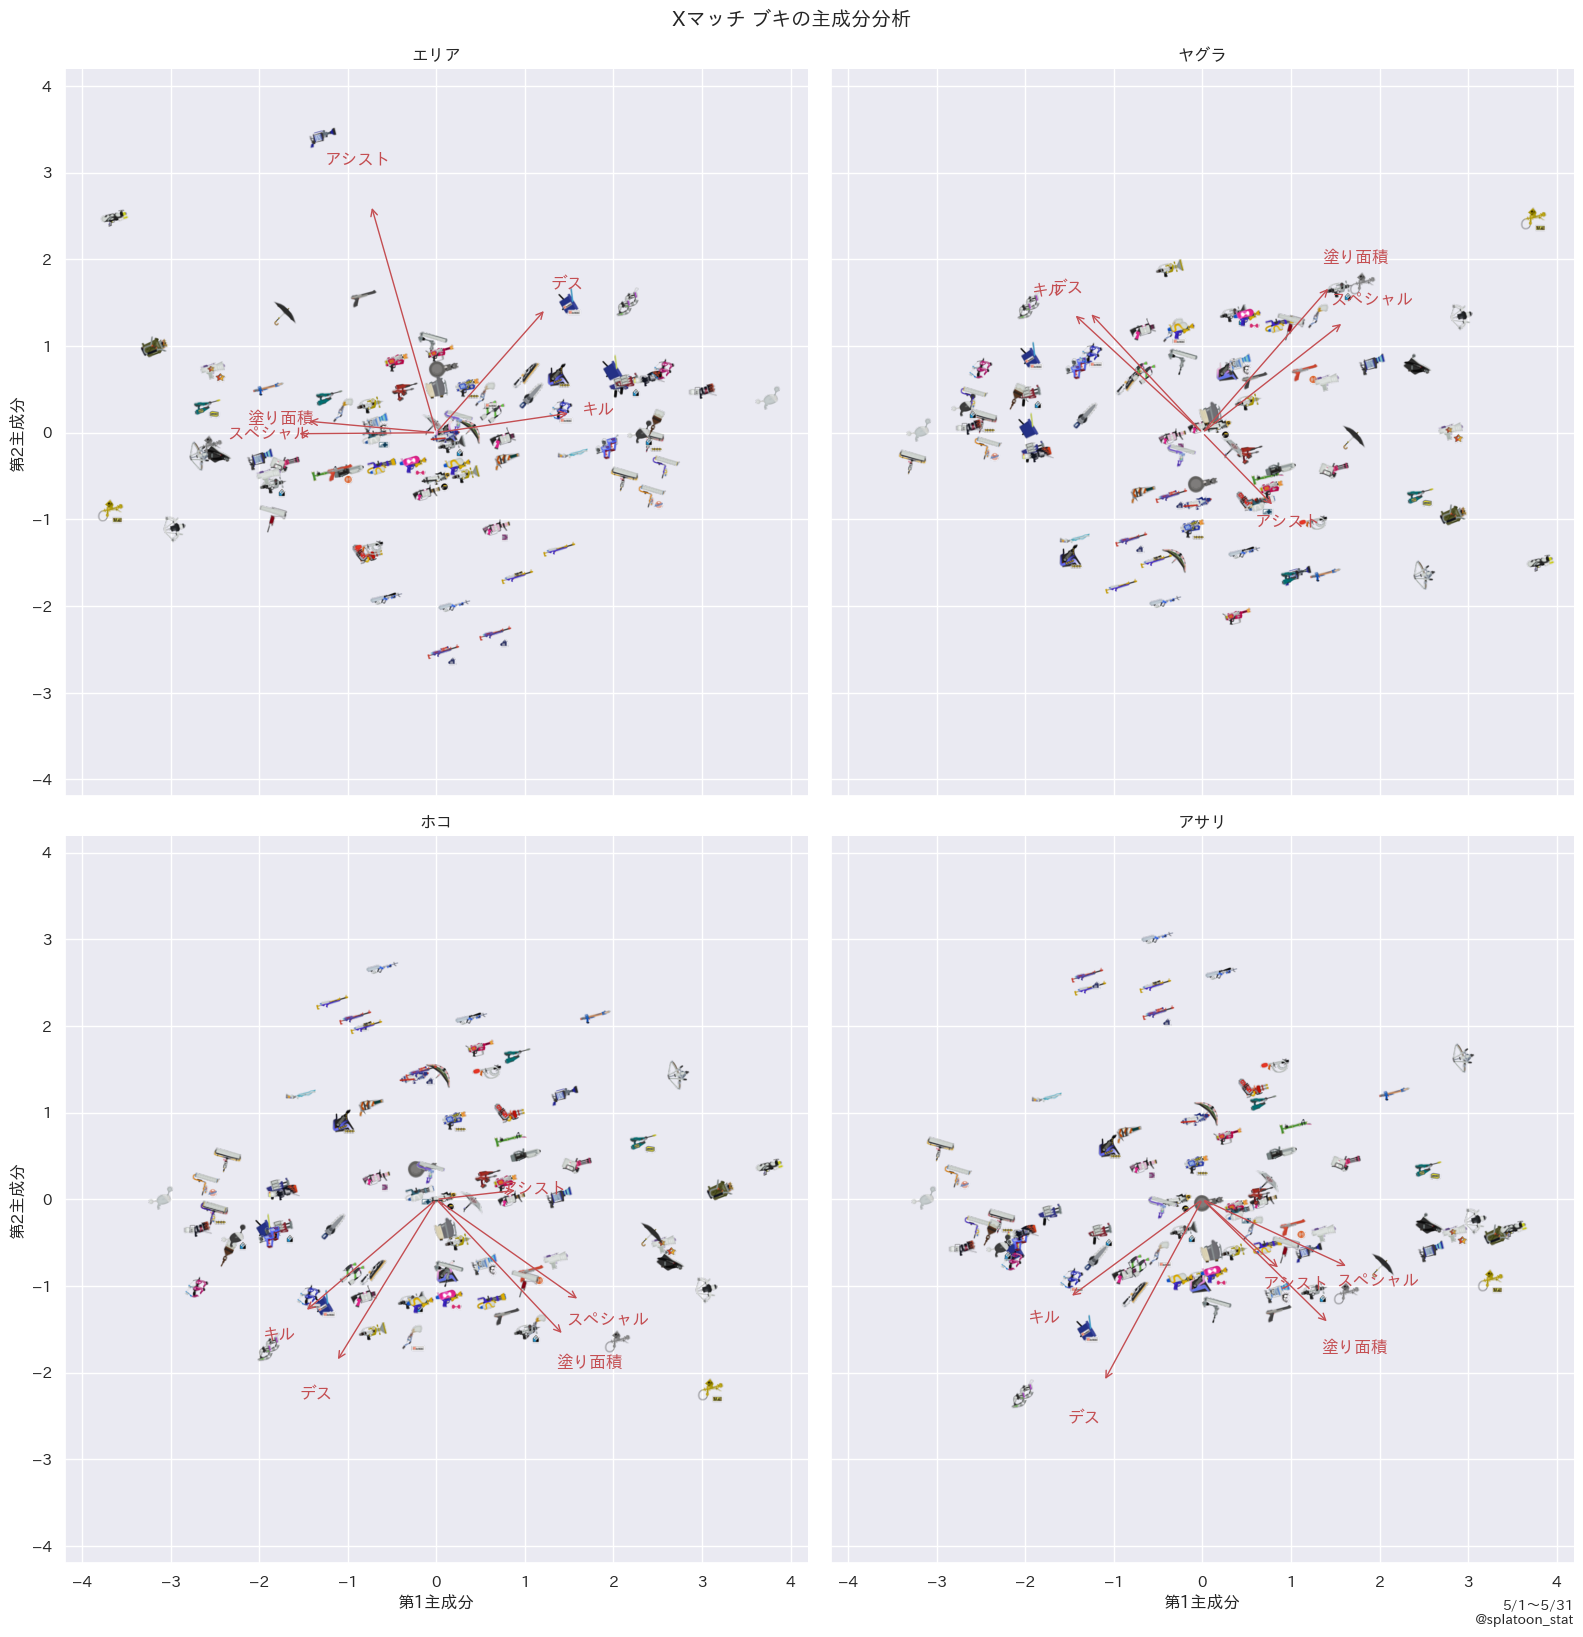

In [5]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "${lobby} ブキの主成分分析", "Weapon PCA in ${lobby}")
i18n.add("pc1", "第1主成分", "1st component")
i18n.add("pc2", "第2主成分", "2nd component")
i18n.add("kill", "キル", "Kill")
i18n.add("assist", "アシスト", "Assist")
i18n.add("death", "デス", "Death")
i18n.add("special", "スペシャル", "Special")
i18n.add("inked", "塗り面積", "Inked")

value_range = max(score[["pc1", "pc2"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=score,
    x="pc1",
    y="pc2",
    col="mode",
    col_wrap=2,
    col_order=d.MODE_ORDER,
    marker="",
    height=8,
)
g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)

g.set(
    xlabel=i18n.t("pc1"),
    ylabel=i18n.t("pc2"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, ax in enumerate(g.axes):
    mode = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode))

    for j, row in score.loc[mode].iterrows():
        weapon = row.name
        xvalue = row["pc1"]
        yvalue = row["pc2"]
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=0.65)
        img.image.axes = ax
        ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
        ax.add_artist(ab)

    for col, item in eigen_vector.loc[mode].items():
        mag = 3
        vec = [item["pc1"], item["pc2"]]
        ax.annotate("", (0, 0), xytext=[x * mag for x in vec], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
        ax.annotate(i18n.t(col), (0, 0), xytext=[x * mag * 1.2 for x in vec], color="r", ha="center", va="center")
    
    if i == 3:
        u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()


In [6]:
score

pc1       pc2       pc3       pc4       pc5
mode  weapon                                                            
area  52gal             0.748095 -0.071791  0.945258 -0.252605 -0.308590
      96gal            -0.109043 -0.689734  0.325550 -0.185584  0.101262
      96gal_deco        0.677009 -1.095079  0.034727 -0.203715  0.053933
      bamboo14mk1      -1.226613 -0.457340 -0.452399 -0.287019 -0.364745
      barrelspinner    -1.706538 -0.346395 -0.545951 -0.203097  0.046365
...                          ...       ...       ...       ...       ...
asari sshooter_collabo  0.128532 -0.849381 -1.034241 -0.492733 -0.014774
      tristringer       2.949002  1.629872  0.873801 -0.365334 -0.595243
      variableroller    0.930980 -0.569710 -1.365962 -0.441919  0.110531
      wakaba            1.375000 -0.375301 -0.847117  0.180746  0.581212
      wideroller       -0.458936 -0.080486  0.104343  1.239338  0.172659

[316 rows x 5 columns]